In [13]:
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.hp import quniform, loguniform
from hyperopt.plotting import main_plot_history, main_plot_histogram, main_plot_vars

import time

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
RANDOM_SEED = 3

### Import datasets

In [3]:
readmissions = pd.read_csv('../data/classification/readmissions_clean.csv')
emissions = pd.read_csv("../data/regression/emissions_cleaned.csv")

In [4]:
def print_elapsed_time(start, end):
    elapsed_time = end - start
    minutes = int(elapsed_time // 60)
    seconds = int(elapsed_time % 60)
    print("Elapsed time: {} minutes, {} seconds".format(minutes, seconds))

### Classification

In [5]:
# Split dataset into X and Y
X = readmissions.drop(['readmitted'], axis=1)
y = readmissions.readmitted

In [6]:
# splitting X and Y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=RANDOM_SEED, test_size=0.2)

In [7]:
def objective(params):
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    max_features = int(params['max_features'])

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
    rf.fit(X_train, y_train)
    
    return -accuracy_score(y_test, rf.predict(X_test))

space = {
    'n_estimators': quniform('n_estimators', 2, 500, 1),
    'max_depth': quniform('max_depth', 1, 50, 1),
    'max_features': quniform('max_features', 3, 10, 1)
}

In [14]:
start = time.time() 
trials = Trials()                               
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials, rstate=np.random.default_rng(RANDOM_SEED))
end = time.time()

100%|██████████| 100/100 [05:25<00:00,  3.26s/trial, best loss: -0.6296]


In [9]:
print("Best Hyperparameters: ", best)

Best Hyperparameters:  {'max_depth': 7.0, 'max_features': 5.0, 'n_estimators': 273.0}


avg best error: -0.6296


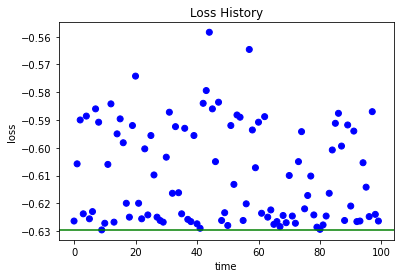

In [15]:
main_plot_history(trials)

Showing Histogram of 100 jobs


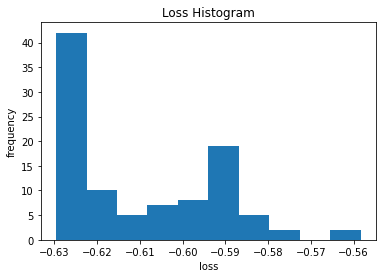

In [17]:
main_plot_histogram(trials)

finite loss range -0.6296 -0.5584 -1.6296


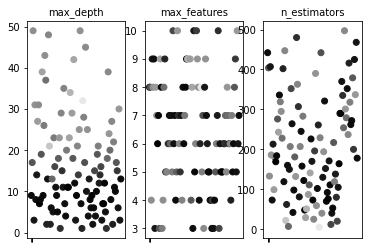

In [16]:
main_plot_vars(trials)

In [33]:
"""HYPEROPT BASED ON MAXIMIZING ACCURACY"""

rf = RandomForestClassifier(max_depth=best['max_depth'], max_features=int(best['max_features']), n_estimators=int(best['n_estimators']))
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6294
Precision: 0.6323777403035413
Recall: 0.48407917383821


In [49]:
print_elapsed_time(start,end)

Elapsed time: 2 minutes, 14 seconds


### Regression

In [36]:
# Split dataset into X and Y
X = emissions.drop('co2_emissions', axis=1)
y = emissions["co2_emissions"]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=RANDOM_SEED, test_size=0.2)

In [42]:
def objective(params):
    n_estimators = int(params['n_estimators'])
    max_depth = params['max_depth']
    max_features = int(params['max_features'])
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
    score = cross_val_score(rf, X_train, y_train, n_jobs=-1, cv=3).mean()
    return -score

space = {
    'n_estimators': quniform('n_estimators', 2, 500, 1),
    'max_depth': loguniform('max_depth', np.log(1), np.log(50)),
    'max_features': quniform('max_features', 3, 10, 1)
}

In [43]:
start = time.time()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)
end = time.time()

100%|██████████| 100/100 [02:14<00:00,  1.34s/trial, best loss: -0.9973735124662598]


In [46]:
print("Best Hyperparameters: ", best)

Best Hyperparameters:  {'max_depth': 17.32022850197896, 'max_features': 10.0, 'n_estimators': 310.0}


In [50]:
print_elapsed_time(start, end)

Elapsed time: 2 minutes, 14 seconds


In [56]:
#HYPEROPT EXPERIMENT
rf = RandomForestRegressor(random_state=RANDOM_SEED , max_depth = best['max_depth'], max_features = int(best['max_features']), n_estimators = int(best['n_estimators']))
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [55]:
# Get performance metrics
MSE = -cross_val_score(rf, X_train,y_train, cv=3, scoring='neg_mean_squared_error').mean()
MAE = -cross_val_score(rf, X_train,y_train, cv=3, scoring='neg_mean_absolute_error').mean()
MAPE = -cross_val_score(rf, X_train,y_train, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
Accuracy = cross_val_score(rf, X_train,y_train, cv=3).mean()

print('MSE: ', MSE, ', MAE: ', MAE, ', MAPE: ', MAPE, 'Accuracy: ', Accuracy)

MSE:  9.06894317355322 , MAE:  1.8720278567997244 , MAPE:  0.0075961756651046165 Accuracy:  0.9973607367109811
